In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family']='SimHei'
columns = ['user_id','order_dt','order_products','order_amount']
df = pd.read_csv('E:/datas/products.txt',names=columns,sep='\s+')
print(df.head())
print(df.info())

   user_id  order_dt  order_products  order_amount
0        1  19970101               1         11.77
1        2  19970112               1         12.00
2        2  19970112               5         77.00
3        3  19970102               2         20.76
4        3  19970330               2         20.76
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
user_id           69659 non-null int64
order_dt          69659 non-null int64
order_products    69659 non-null int64
order_amount      69659 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB
None


## 数据清洗

In [44]:
# order_dt是int类型，需要转化为datetime
df['order_dt'] = pd.to_datetime(df['order_dt'],format='%Y%m%d')
# 新增列月份
df['month'] = df.order_dt.values.astype('datetime64[M]')
print(df.head())

   user_id   order_dt  order_products  order_amount      month
0        1 1997-01-01               1         11.77 1997-01-01
1        2 1997-01-12               1         12.00 1997-01-01
2        2 1997-01-12               5         77.00 1997-01-01
3        3 1997-01-02               2         20.76 1997-01-01
4        3 1997-03-30               2         20.76 1997-03-01


## 探索性分析

In [3]:
df.describe()

,user_id,order_products,order_amount
count,69659.000000,69659.000000,69659.000000
mean,11470.854592,2.410040,35.893648
std,6819.904848,2.333924,36.281942
min,1.000000,1.000000,0.000000
25%,5506.000000,1.000000,14.490000
50%,11410.000000,2.000000,25.980000
75%,17273.000000,3.000000,43.700000
max,23570.000000,99.000000,1286.010000


- 商品数均值为2.4，最大值为99，有一定干扰
- 金额均值为35，最大值为1286，平均差为36，干扰比较大

In [ ]:
# 按照年月分组
grouped_month = df.groupby('month')

Text(0.5,1,'每月用户数变化趋势')

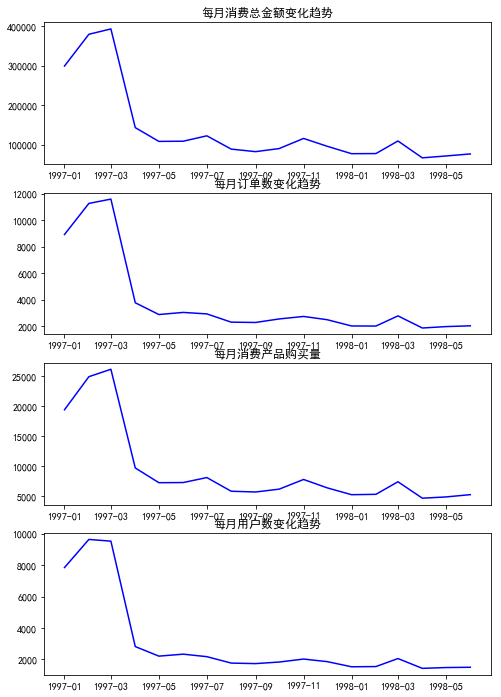

In [4]:
fig = plt.figure(figsize = (8,12))
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)
ax1.plot(grouped_month.order_amount.sum(),c='blue')
ax1.set_title('每月消费总金额变化趋势')
ax2.plot(grouped_month.user_id.count(),c='blue')
ax2.set_title('每月订单数变化趋势')
ax3.plot(grouped_month.order_products.sum(),c='blue')
ax3.set_title('每月消费产品购买量')
ax4.plot(grouped_month.user_id.apply(lambda x:len(x.drop_duplicates())),c='blue')
ax4.set_title('每月用户数变化趋势')

- 可以看到总金额，订单数，购买量，用户数四条曲线变化一致
- 前三个月是高峰，从四月开始大幅度下降，往后趋于平稳
- 可能是前三个月有大的促销活动，吸引力大量新用户
- 但是新用户粘度低，从四月份开始用户大量流失

### 用户消费金额和购买数量描述统计

In [6]:
grouped_user = df.groupby('user_id')
grouped_user.sum().describe()

,order_products,order_amount
count,23570.000000,23570.000000
mean,7.122656,106.080426
std,16.983531,240.925195
min,1.000000,0.000000
25%,1.000000,19.970000
50%,3.000000,43.395000
75%,7.000000,106.475000
max,1033.000000,13990.930000


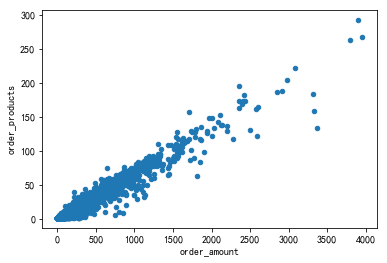

In [7]:
#方差比较大，极值有很大干扰
grouped_user.sum().query('order_amount < 4000').plot.scatter(x='order_amount',y='order_products')

### 用户消费金额的分布图

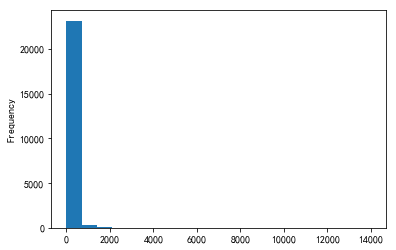

In [8]:
grouped_user.sum().order_amount.plot.hist(bins=20)

> 可见大部分客户消费并不高，符合二八法则

### 用户购买数量分布图

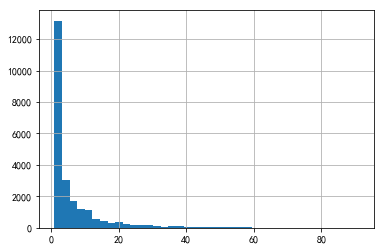

In [9]:
grouped_user.sum().query('order_products<92').order_products.hist(bins = 40)

### 用户累计消费金额占比

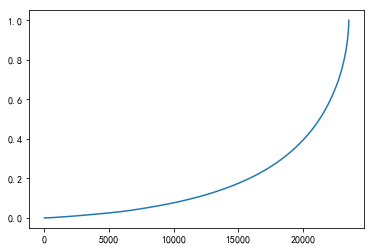

In [10]:
user_cumsum = grouped_user.sum().sort_values('order_amount').apply(lambda x: x.cumsum() / x.sum())
user_cumsum.reset_index().order_amount.plot()

- 一半客户仅仅贡献了15%销售额
- 而前5000客户贡献了60%销售额

### 用户消费行为分析

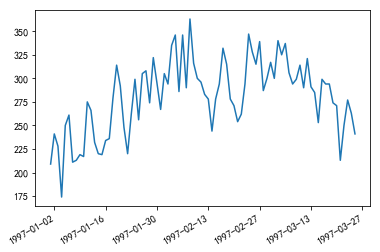

In [11]:
# 1.第一次购买时间分布
grouped_user.min().order_dt.value_counts().plot()

- 第一次购买时间主要集中在1-3月
- 说明从四月份开始新用户很少

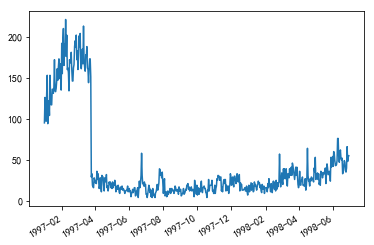

In [12]:
# 最后一次购买时间分布
grouped_user.max().order_dt.value_counts().plot()

- 最后一次购买时间分布比较广，但是主要集中在1-3月
- 说明很多人只购买了一次

#### 新老客户消费对比

In [13]:
user_life = grouped_user.order_dt.agg(['min','max'])
user_life.head()

,min,max
user_id,,
1,1997-01-01,1997-01-01
2,1997-01-12,1997-01-12
3,1997-01-02,1998-05-28
4,1997-01-01,1997-12-12
5,1997-01-01,1998-01-03


In [14]:
# 统计频次
(user_life['min']==user_life['max']).value_counts()

True     12054
False    11516
dtype: int64

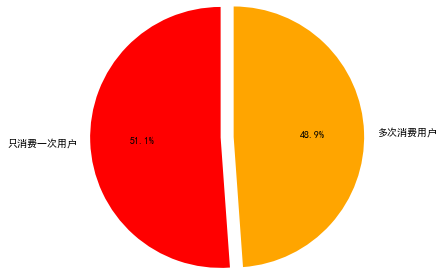

In [22]:
# 绘制成图
rate = (user_life['min'] == user_life['max']).value_counts()
labels = ['只消费一次用户','多次消费用户']
plt.axis('equal') # 保证长宽相等
plt.pie(rate,explode=(0,0.15),labels=labels,autopct='%2.1f%%',startangle=90,colors=['r','orange'],radius=1.5)
plt.show()

> 大约一半用户只消费了一次

### RFM用户分层

In [16]:
rfm = df.pivot_table(index='user_id',
                     values=['order_products','order_amount','order_dt'],
                     aggfunc={
                         'order_dt':'max',
                         'order_amount':'sum',
                         'order_products':'count'})
rfm.head()

,order_amount,order_dt,order_products
user_id,,,
1,11.77,1997-01-01,1
2,89.00,1997-01-12,2
3,156.46,1998-05-28,6
4,100.50,1997-12-12,4
5,385.61,1998-01-03,11


In [17]:
# 最近一次消费时间间隔
rfm['order_dt'].max()-rfm['order_dt'].head()

user_id
1   545 days
2   534 days
3    33 days
4   200 days
5   178 days
Name: order_dt, dtype: timedelta64[ns]

In [17]:
rfm['R'] = (rfm['order_dt'].max()-rfm['order_dt']) / np.timedelta64(1,'D')
rfm.rename(columns = {'order_products':'F','order_amount':'M'},inplace=True)
rfm.head()

,M,order_dt,F,R
user_id,,,,
1,11.77,1997-01-01,1,545.0
2,89.00,1997-01-12,2,534.0
3,156.46,1998-05-28,6,33.0
4,100.50,1997-12-12,4,200.0
5,385.61,1998-01-03,11,178.0


In [18]:
# 计算与均值之差
rfm[['R','F','M']].apply(lambda x:x-x.mean()).head()

,R,F,M
user_id,,,
1,177.778362,-1.955409,-94.310426
2,166.778362,-0.955409,-17.080426
3,-334.221638,3.044591,50.379574
4,-167.221638,1.044591,-5.580426
5,-189.221638,8.044591,279.529574


In [19]:
def rfm_func(x):
    '''关于字典d的说明
    
    R=1表示最近一次购买比较远，F=1表示购买频率比较大，M=1表示购买金额比较高
    '''
    level = x.apply(lambda x:'1' if x>= 0 else '0')
    label = level.R + level.F + level.M
    d = {
        '111':'重要价值客户', 
        '011':'重要保持客户',
        '101':'重要挽留客户',
        '001':'重要发展客户',
        '110':'一般价值客户',
        '010':'一般保持客户',
        '100':'一般挽留客户',
        '000':'一般发展客户'
    }
    result = d[label]
    return result
rfm['label'] = rfm[['R','F','M']].apply(lambda x:x-x.mean()).apply(rfm_func,axis=1)
rfm.head()

,M,order_dt,F,R,label
user_id,,,,,
1,11.77,1997-01-01,1,545.0,一般挽留客户
2,89.00,1997-01-12,2,534.0,一般挽留客户
3,156.46,1998-05-28,6,33.0,重要保持客户
4,100.50,1997-12-12,4,200.0,一般保持客户
5,385.61,1998-01-03,11,178.0,重要保持客户


In [20]:
rfm.groupby('label').sum()

,M,F,R
label,,,
一般价值客户,36200.21,1782,237754.0
一般保持客户,141127.20,7371,309037.0
一般发展客户,75781.48,3064,311519.0
一般挽留客户,409272.88,15589,6750356.0
重要价值客户,103260.14,1950,194091.0
重要保持客户,1591666.47,38490,517048.0
重要发展客户,46158.16,536,56855.0
重要挽留客户,96849.09,877,278754.0


In [21]:
s = rfm.groupby('label').sum()
s.loc['重要保持客户','M']/(s['M'].sum())

0.6365862177168443

> 重要保持客户贡献了销售额的63%

#### 各类用户数量

In [23]:
rfm.groupby('label').count()

,M,order_dt,F,R
label,,,,
一般价值客户,543,543,543,543
一般保持客户,1974,1974,1974,1974
一般发展客户,1532,1532,1532,1532
一般挽留客户,13608,13608,13608,13608
重要价值客户,449,449,449,449
重要保持客户,4617,4617,4617,4617
重要发展客户,268,268,268,268
重要挽留客户,579,579,579,579


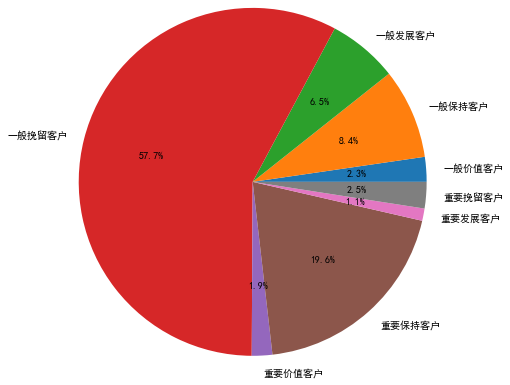

In [51]:
# 各类类型用户占比
use_c = rfm.groupby('label').count()
plt.axis('equal')
labels = ['一般价值客户','一般保持客户','一般发展客户','一般挽留客户','重要价值客户','重要保持客户','重要发展客户','重要挽留客户']
plt.pie(use_c['M'],
       autopct='%3.1f%%',
        labels = labels,
       radius=2)
plt.show()

- 一般挽留客户也就是低价值客户占据总用户数的57.7%
- 重要保持客户也就是对营收贡献最大的那群客户占19.6%

### 活跃度划分

In [25]:
pivoted_counts = df.pivot_table(index = 'user_id',
                                  columns = 'month',
                                  values = 'order_dt',
                                  aggfunc = 'count').fillna(0)
pivoted_counts.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#消费过的为1 ，没消费过的为0
data_purchase = pivoted_counts.applymap(lambda x: 1 if x > 0 else 0)
data_purchase.tail()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
23566,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23567,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23568,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23569,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23570,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
# 划分活跃
def active_status(data):
    status = []
    for i in range(18):
        
        #若本月没有消费
        if data[i] == 0:
            if len(status) > 0:
                if status[i-1] == 'unreg':
                    status.append('unreg')
                else:
                    status.append('unactive')
            else:
                status.append('unreg')                  
        #若本月消费
        else:
            if len(status) == 0:
                status.append('new')
            else:
                if status[i-1] == 'unactive':
                    status.append('return')
                elif status[i-1] == 'unreg':
                    status.append('new')
                else:
                    status.append('active')
    return pd.Series(status, index = pivoted_counts.columns)

#### 若本月没有消费
- 若之前是未注册，则依旧未注册
- 若之前有消费，则为流失/不活跃
- 其他情况，为未注册

#### 若本月有消费
- 若是第一次消费，则为新用户
- 如果之前有过消费，则上个月为不活跃，则为回流
- 如果上个月为未注册，则为新用户
- 除此之外，为活跃

In [28]:
purchase_stats = data_purchase.apply(active_status,axis=1,result_type ='expand')
purchase_stats.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
3,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
4,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
5,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive


In [29]:
# 每月各种类型用户数量
purchase_status_ct = purchase_stats.replace('unreg',np.NaN).apply(lambda x : pd.value_counts(x))
purchase_status_ct

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
active,NaN,1157.0,1681,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624.0,632.0,512.0,472.0,571.0,518.0,459.0,446.0
new,7846.0,8476.0,7248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return,NaN,NaN,595,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1404.0,1232.0,1025.0,1079.0,1489.0,919.0,1029.0,1060.0
unactive,NaN,6689.0,14046,20748.0,21356.0,21231.0,21390.0,21798.0,21831.0,21731.0,21542.0,21706.0,22033.0,22019.0,21510.0,22133.0,22082.0,22064.0


- 前三个月有大量新用户加入，活跃用户数也多
- 后面没有新用户加入，活跃用户也大幅下降，最后趋于平稳

### 用户购买周期

In [31]:
# 订单时间间隔
order_diff = grouped_user.apply(lambda x:x.order_dt - x.order_dt.shift())
order_diff.head(20)

user_id    
1        0         NaT
2        1         NaT
         2      0 days
3        3         NaT
         4     87 days
         5      3 days
         6    227 days
         7     10 days
         8    184 days
4        9         NaT
         10    17 days
         11   196 days
         12   132 days
5        13        NaT
         14    13 days
         15    21 days
         16    66 days
         17    50 days
         18    16 days
         19    36 days
Name: order_dt, dtype: timedelta64[ns]

In [32]:
order_diff.describe()

count                      46089
mean     68 days 23:22:13.567662
std      91 days 00:47:33.924168
min              0 days 00:00:00
25%             10 days 00:00:00
50%             31 days 00:00:00
75%             89 days 00:00:00
max            533 days 00:00:00
Name: order_dt, dtype: object

- 用户订单平均时间间隔为68天
- 标准差91比较大，数据波动大

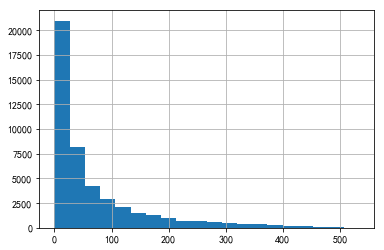

In [33]:
(order_diff / np.timedelta64(1,'D')).hist(bins=20)

- 购买周期大部分在0-100天

### 用户生命周期

In [34]:
# 整体生命周期
(user_life['max'] - user_life['min']).describe()

count                       23570
mean     134 days 20:55:36.987696
std      180 days 13:46:43.039788
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%             294 days 00:00:00
max             544 days 00:00:00
dtype: object

- 用户平均生命周期为134天
- 中位数为0是因为有一半客户只购买了一次

In [42]:
user_cycle = (user_life['max'] - user_life['min']) / np.timedelta64(1,'D')

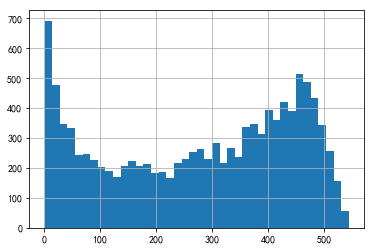

In [43]:
# 去除只购买一次的客户，其余客户生命周期分布图
user_cycle[user_cycle>0].hist(bins = 40)

- 0-50天的客户占据很大一部分
- 还有部分用户集中在50-350属于普通用户
- 集中在350-550这部分高质量用户忠诚度比较高

### 复购率
复购率
- 一个月内，购买多次的用户占比

In [41]:
pivoted_counts.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# 复购率
# 购买1次以上的赋值为1，购买1次的赋值为0，没有购买的赋值为空
purchase_r = pivoted_counts.applymap(lambda x: 1 if x > 1 else np.NaN if x == 0 else 0)
purchase_r.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


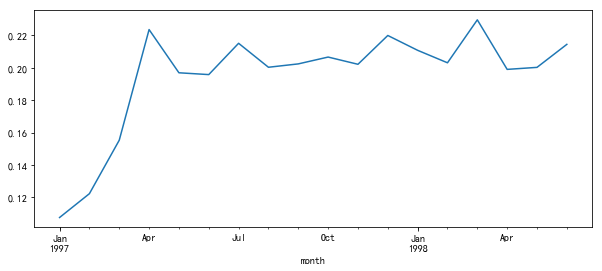

In [43]:
(purchase_r.sum() / purchase_r.count()).plot(figsize = (10,4))

- 前三个月有大量新用户且只购买了一次复购率比较低
- 往后复购率维持在20%左右